Instructions for updating:
non-resource variables are not supported in the long term
11493376/11490434 [==============================] - 0s 0us/step
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
epoch 1 ----Validation accuracy without BN: 0.106416665
epoch 2 ----Validation accuracy without BN: 0.106
epoch 3 ----Validation accuracy without BN: 0.106
epoch 4 ----Validation accuracy without BN: 0.17275
epoch 5 ----Validation accuracy without BN: 0.106
epoch 6 ----Validation accuracy without BN: 0.20516667
epoch 7 ----Validation accuracy without BN: 0.106
epoch 8 ----Validation accuracy without BN: 0.207
epoch 9 ----Validation accuracy without BN: 0.28841665
epoch 10 ----Validation accuracy without BN: 0.22775
epoch 11 ----Validation accuracy without BN: 0.28675
epoch 12 ----Validation accuracy without BN: 0.31891668
epoch 13 ----Validation accuracy without BN: 0.30775
epoch 14 ----Validation accuracy with

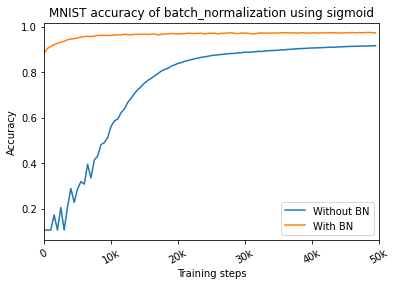

In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior() 
%matplotlib inline
import matplotlib.pyplot as plt

#load the data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# preproccess
X_train = X_train.astype(np.float32).reshape(60000, 784)
X_test = X_test.astype(np.float32).reshape(10000, 784)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_train = X_train/ 255.0
X_test = X_test/ 255.0

#split dataset into validation and train base on the fraction of valiation 
fraction = 0.2
split = int((1.0 - fraction) * X_train.shape[0])
X_train, X_valid = X_train[:split], X_train[split:]
y_train, y_valid = y_train[:split], y_train[split:]

#initial parameter
batch_size = 500
lr = 0.05
n_epochs = 100

def helper(X, y, batch_size):
    idx = np.random.permutation(len(X))
    temp = np.array_split(idx, len(X) // batch_size)
    output_array = []
    for i in temp:
        X_batch, y_batch = X[i], y[i]
        out = []
        out.append(X_batch)
        out.append(y_batch)
        output_array.append(out)
    return output_array
## Placeholders     
X = tf.placeholder(tf.float32, shape=(None, 784), name="input")
y = tf.placeholder(tf.int32, shape=(None),  name="output")
training = tf.placeholder_with_default(False, shape=(), name='training')
acc, acc_bn = [], []

#RNN without batchnormaliztion
with tf.name_scope("RNN"):
    layer1 = tf.layers.dense(X, 100, name="layer1")
    act1 = tf.nn.sigmoid(layer1)
    Layer2 = tf.layers.dense(act1, 100, name="layer2")
    act2 = tf.nn.sigmoid(Layer2)
    Layer3 = tf.layers.dense(act2, 100, name="layer3")
    act3 = tf.nn.sigmoid(Layer3)
    output = tf.layers.dense(act3, 10, name="outputs")
    x_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=output)
    loss = tf.reduce_mean(x_entropy, name="loss_function")
    optimizer = tf.train.GradientDescentOptimizer(lr)
    training_ops = optimizer.minimize(loss)
    correct = tf.nn.in_top_k(output, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
extra_graphkeys_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(1, n_epochs+1):
        output_array = helper(X_train, y_train, batch_size)
        for X_batch, y_batch in output_array:
            sess.run([training_ops, extra_graphkeys_update_ops], feed_dict={training: True, X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        acc.append(acc_val)
        print("epoch", epoch, "----Validation accuracy without BN:", acc_val)
        
#RNN with batchnormaliztion
with tf.name_scope("RNN_BN"):
    layer1_bn = tf.layers.dense(X, 100, name="layer1_bn")
    bn1 = tf.layers.batch_normalization(layer1_bn, training=training, momentum=0.9)
    bn_act1 = tf.nn.sigmoid(bn1)

    layer2_bn = tf.layers.dense(bn_act1, 100, name="layer2_bn")
    bn2 = tf.layers.batch_normalization(layer2_bn, training=training, momentum=0.9)
    bn_act2 = tf.nn.sigmoid(bn2)

    layer3_bn = tf.layers.dense(bn_act2, 100, name="layer3_bn")
    bn3 = tf.layers.batch_normalization(layer3_bn, training=training, momentum=0.9)
    bn_act3 = tf.nn.sigmoid(bn3)

    output2 = tf.layers.dense(bn_act3, 10, name="output_bn")
    output_bn = tf.layers.batch_normalization(output2, training=training, momentum=0.9)
    
    x_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=output_bn)
    loss_bn = tf.reduce_mean(x_entropy, name="loss_function")
    optimizer = tf.train.GradientDescentOptimizer(lr)
    training_ops_bn = optimizer.minimize(loss_bn)
    correct = tf.nn.in_top_k(output_bn, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
extra_graphkeys_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(1, n_epochs+1):
        output_array = helper(X_train, y_train, batch_size)
        for X_batch, y_batch in output_array:
            sess.run([training_ops_bn, extra_graphkeys_update_ops], feed_dict={training: True, X: X_batch, y: y_batch})
        acc_val_bn = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        acc_bn.append(acc_val_bn)
        #print("epoch", epoch, "----Validation accuracy without BN:", acc_val_bn)
    


figure, ax = plt.subplots()
ax.set_title('MNIST accuracy of batch_normalization using sigmoid')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.plot(acc, label='Without BN')
ax.plot(acc_bn, label='With BN')
ax.legend(loc=4)
ax.set_xlim([0,100])
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_xticklabels(['0', '10k', '20k', '30k','40k', '50k'], rotation=30, fontsize='medium')
plt.show()

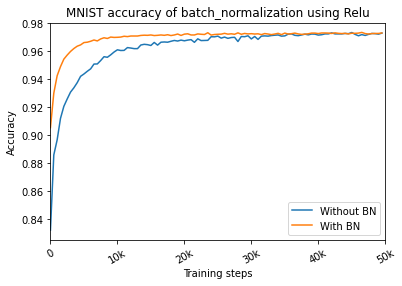

In [ ]:
acc_relu, acc_bn_relu = [], []

#RNN without batchnormaliztion
with tf.name_scope("RNN_relu"):
    layer1_relu = tf.layers.dense(X, 100, name="layer1_relu")
    act1_relu = tf.nn.relu(layer1_relu)
    layer2_relu = tf.layers.dense(act1_relu, 100, name="layer2_relu")
    act2_relu = tf.nn.relu(layer2_relu)
    layer3_relu = tf.layers.dense(act2_relu, 100, name="layer3_relu")
    act3_relu = tf.nn.relu(layer3_relu)
    output_relu = tf.layers.dense(act3_relu, 10, name="outputs_relu")
    x_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=output_relu)
    loss = tf.reduce_mean(x_entropy, name="loss_function_relu")
    optimizer = tf.train.GradientDescentOptimizer(lr)
    training_ops = optimizer.minimize(loss)
    correct = tf.nn.in_top_k(output_relu, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
extra_graphkeys_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(1, n_epochs+1):
        output_array = helper(X_train, y_train, batch_size)
        for X_batch, y_batch in output_array:
            sess.run([training_ops, extra_graphkeys_update_ops], feed_dict={training: True, X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        acc_relu.append(acc_val)
        #print("epoch", epoch, "----Validation accuracy without BN:", acc_val)
        
#RNN with batchnormaliztion
with tf.name_scope("RNN_relu_BN"):
    layer1_bn_relu = tf.layers.dense(X, 100, name="layer1_bn_relu")
    bn1_relu = tf.layers.batch_normalization(layer1_bn_relu, training=training, momentum=0.9)
    bn_act1_relu = tf.nn.relu(bn1_relu)

    layer2_bn_relu = tf.layers.dense(bn_act1_relu, 100, name="layer2_bn_relu")
    bn2_relu = tf.layers.batch_normalization(layer2_bn_relu, training=training, momentum=0.9)
    bn_act2_relu = tf.nn.relu(bn2_relu)

    layer3_bn_relu = tf.layers.dense(bn_act2_relu, 100, name="layer3_bn_relu")
    bn3_relu = tf.layers.batch_normalization(layer3_bn_relu, training=training, momentum=0.9)
    bn_act3_relu = tf.nn.relu(bn3_relu)

    output2_relu = tf.layers.dense(bn_act3_relu, 10, name="output_bn_relu")
    output_bn_relu = tf.layers.batch_normalization(output2_relu, training=training, momentum=0.9)
    
    x_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=output2_relu)
    loss_bn = tf.reduce_mean(x_entropy, name="loss_function_relu")
    optimizer = tf.train.GradientDescentOptimizer(lr)
    training_ops_bn = optimizer.minimize(loss_bn)
    correct = tf.nn.in_top_k(output2_relu, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
extra_graphkeys_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(1, n_epochs+1):
        output_array = helper(X_train, y_train, batch_size)
        for X_batch, y_batch in output_array:
            sess.run([training_ops_bn, extra_graphkeys_update_ops], feed_dict={training: True, X: X_batch, y: y_batch})
        acc_val_bn = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        acc_bn_relu.append(acc_val_bn)
        #print("epoch", epoch, "----Validation accuracy without BN:", acc_val_bn)
    
figure, ax = plt.subplots()
ax.set_title('MNIST accuracy of batch_normalization using Relu')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.plot(acc_relu, label='Without BN')
ax.plot(acc_bn_relu, label='With BN')
ax.legend(loc=4)
ax.set_xlim([0,100])
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_xticklabels(['0', '10k', '20k', '30k','40k', '50k'], rotation=30, fontsize='medium')
plt.show()
